In [85]:
# Standard modules needed
import numpy as np
import pandas as pd
import datetime as dt
from types import SimpleNamespace
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Windmill industry in Denmark

This exercise deals with the power generated by windmills in Denmark. As windmills are considered an important element in the transition to a zero emission economy we should take a closer look at the electricity production stemming from them.

To this end, you need to download the official data set containing all windmills in Denmark which produced by the Danish Energy Agency. You can download it using the module `requests` and then save it as the xlsx file `windmills.xlsx`. This is done in the cell below.   


In [86]:
import requests

url = "https://ens.dk/sites/ens.dk/files/Statistik/anlaeg.xlsx"
r = requests.get(url)

with open('windmills.xlsx', 'wb') as xls_file:
    xls_file.write(r.content)   


*Note: `requests` is in the Anaconda distribution, so it should be available to you. If it is not, install it by running `python -m pip install requests` in your terminal.*    

By inspecting `windmills.xlsx` you'll see it has two sheets: 1) `IkkeAfmeldte-Existing turbines` which holds mills (turbines) currently in use and 2) `Afmeldte-Decommissioned` which are no longer in service. Throughout the rest of the exercise, you need to use data from both of them.


### Question 1

1. Load the two sheets of `windmills.xlsx` into your notebook and combine them into one pandas DataFrame. Note that you need to do some data cleaning in the process. For instance, you can disregard the variables which are not present in both sheets. You can decide for yourself whether you want to use English or Danish column names.  

First we clean the data and combine two sheets of the windmills.xlsx

In [87]:
pd.set_option('display.max_columns',200) # I want to see all the columns
pd.set_option('display.max_rows',735) 

In [88]:
#downloading both excel sheet
ex = pd.ExcelFile('windmills.xlsx')
ex1 = pd.read_excel(ex, 'IkkeAfmeldte-Existing turbines', skiprows=7)
ex2 = pd.read_excel(ex, 'Afmeldte-Decommissioned', skiprows=7)

In [89]:
#The shape of the files
print(ex1.shape)
print(ex2.shape)

(6309, 63)
(3455, 64)


In [90]:
#list of indicers we want to drop
dr = []
for i in range(2,10):
    dr.append(i)

In [91]:
ex1.drop(index=dr, inplace=True)
ex1.reset_index(inplace = True, drop = True) 
ex1.loc[1,'Historic production figures (kWh):':'Unnamed: 62'] = ex1.loc[0,'Historic production figures (kWh):':'Unnamed: 62']
ex1.columns = ex1.iloc[1,:]
ex1.drop(index=[0,1], inplace=True)

In [92]:
ex2.drop(index=dr, inplace=True)
ex2.reset_index(inplace = True, drop = True) # Drop old index too
ex2.loc[1,'Historic production figures (kWh):':'Unnamed: 63'] = ex2.loc[0,'Historic production figures (kWh):':'Unnamed: 63']
ex2.columns = ex2.iloc[1,:]
ex2.drop(index=[0,1,3446], inplace=True)

In [93]:
diff_var = [y for y in ex1.columns.unique() if y not in ex2.columns.unique()] 
print(f'variables in ex1 sheet, but not in ex2: {diff_var}')

variables in ex1 sheet, but not in ex2: ['Manufacture', 'Model', 'Local authority no', 'Local authority\nname']


In [94]:
# We drop those variables which are not in both sheets
ex1.drop(columns=diff_var,inplace = True) 

In [95]:
fin = pd.concat([ex2, ex1])
fin.reset_index(inplace = True, drop = True) 

2. Plot the development in total electricity production from windmills between 1977-2021. You may use GWh (1 million KWh) as unit. 

We divede KWh by 1,000,000 in order to get GWh 

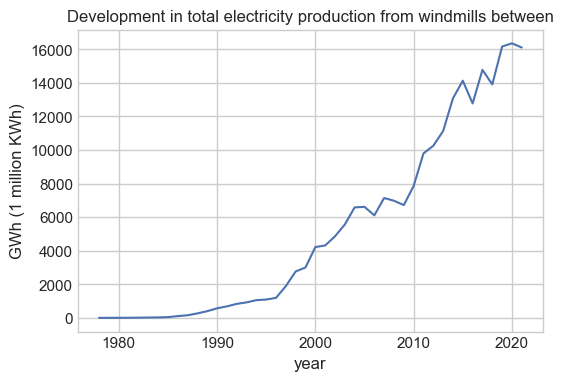

In [96]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('GWh (1 million KWh)')
ax.set_xlabel('year')
plt.title('Development in total electricity production from windmills between')
ax.plot(fin.loc[9742,1978:2021] / 1000000);

### Question 2

We now want to know how the capacity of electricity production has changed over the years. For this we need two variables `Date of original connection to grid` and `Capacity (kW)`. The first indicates when a mill was initiated and the other its production capacity. 
1. Calculate and plot the development in **average**  and  **maximum** capacity of turbines based on their year of initialization (1977-2021)  
    **Note:** capacity is measured in KW, so you need to multiply with the number of hours pr year to make it comparable with annual production. 
2. To get a cleaner view of the trends, compute and plot the 7 year moving average of annual mean capacity and annual max capacity.   

    $\text{ma}^7(x_t) = \frac{x_{t-3}+x_{t-2}+...+x_{t}+...+x_{t+3}}{7}$
3. Finally, compute the **total capacity** of all windmills in Denmark in each year. Plot total capacity together with actual production as calculated in Question 1.  
    **Note:** the capacity of a turbine should only be included for the years when it is connected to the grid.    

In [97]:
fin_2 = fin.copy()
two = fin_2.loc[:,1977:2021].multiply(fin_2.loc[:,'Capacity (kW)'], axis="index")
two['date'] = fin_2.loc[:,'Date of original connection to grid']
two['date2'] = fin_2.loc[:,'Date of decommissioning']
# We create a column with year
two['date'] = pd.to_datetime(two['date'],format='%Y%m%d')
two['year'] = pd.DatetimeIndex(two['date']).year

In [98]:
avg = []
for i in two.loc[:,1977:2021].index:
    avg.append(two.loc[i,1977:2021].mean())
two['average'] = avg

In [99]:
maxx = []
for i in two.loc[:,1977:2021].index:
    maxx.append(two.loc[i,1977:2021].max())
two['max'] = maxx

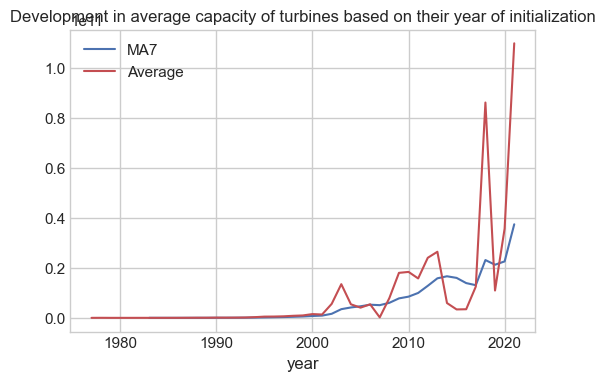

In [100]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('year')
plt.title('Development in average capacity of turbines based on their year of initialization')
ax.plot(two.groupby(['year'])['average'].mean().rolling(7).mean(), label='MA7')
ax.plot(two.groupby(['year'])['average'].mean(), color='r', label='Average')
ax.legend();

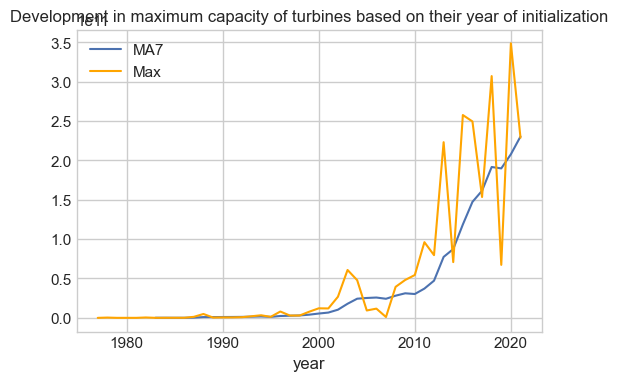

In [101]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('year')
plt.title('Development in maximum capacity of turbines based on their year of initialization')
ax.plot(two.groupby(['year'])['max'].max().rolling(7).mean(), label='MA7')
ax.plot(two.groupby(['year'])['max'].max(), color='orange', label='Max')
ax.legend();

In [102]:
fin_2['date'] = fin_2.loc[:,'Date of original connection to grid']
fin_2['date2'] = fin_2.loc[:,'Date of decommissioning']

fin_2['date'] = pd.to_datetime(fin_2['date'],format='%Y%m%d')
fin_2['year'] = pd.DatetimeIndex(fin_2['date']).year

fin_2['date2'] = pd.to_datetime(fin_2['date2'],format='%Y%m%d')
fin_2['year2'] = pd.DatetimeIndex(fin_2['date2']).year

In [103]:
three = fin_2.loc[:,['Capacity (kW)','year','year2']]
three['year2'] = three['year2'].replace(np.nan, 2022)

In [104]:
cap = []
for i in fin_2.loc[:,1977:2021].columns:
    cap.append(three[(three['year'] == i) & (three['year2'] >= i)]['Capacity (kW)'].sum())

In [105]:
cap_h = []
for i in cap:
    cap_h.append(i * 8765.81277/1000000)

In [106]:
cap_acc = []
for i in cap_h:
    cap_acc.append(i+i)

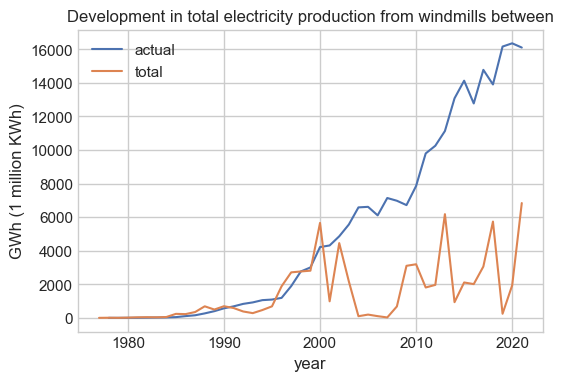

In [107]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('GWh (1 million KWh)')
ax.set_xlabel('year')
plt.title('Development in total electricity production from windmills between')
ax.plot(fin.loc[9742,1978:2021]/1000000, label='actual')
ax.plot(fin_2.loc[:,1977:2021].columns.tolist(), cap_h, label='total')
plt.legend();

### Question 3

There is a lot of debate about the visual impact on the landscape from windmills. This exercise deals with the relationship between windmill size and productivity to get a sense of the tradeoff. You can solve it in many different ways depending on your preferences. The important thing is that the results are clear. 

1. Compute and plot the relationship between height of windmills and their electricity production in 2021. The variable `Hub height (m)` indicates the height of a mill in meters. One possible approach is to discretize the height variable and compute the median electricity production within each bin. But you can also apply a statistical model of your own choosing.
2. Repeat the method you chose above, but now group over the type of location as well. Locations are described by the variable `Type of location` and can be either *off-shore* ("HAV") or *on-shore* ("LAND","Land"). When plotting the results, use common limits on the y-axis for better comparison.  
4. Finally, we dig into the productivity of on-shore vs. off-shore mills.   
Compute and plot the *average difference* between annual capacity and annual production for mills on-shore and mills off-shore in each year 1990-2021.  

In [108]:
# You may need this package
!conda install -c conda-forge statsmodels
!pip install seaborn

Solving environment: done

# All requested packages already installed.



In [109]:
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.patches as mpatches

In [110]:
opg3 = fin.copy()
opg31 = opg3.loc[:, ['Hub height (m)', 2021]].dropna()
opg31.rename(columns = {'Hub height (m)': 'height',2021 : 'y2021'}, inplace=True)
opg31['height'] = opg31['height'].astype(float)

In [111]:
# Parameters
rho = 8.0
nu = 0.1
kappa = 1  
beta = 0.90

tau = 0.8
gamma = 1.2
ybar = 1.5
r = 0.04
p = 0.5
Delta = 0.4

m_min = tau+1e-5    # minimum value for m - must be possible to pay for studying
m_max = 5.0         # maximum value for m


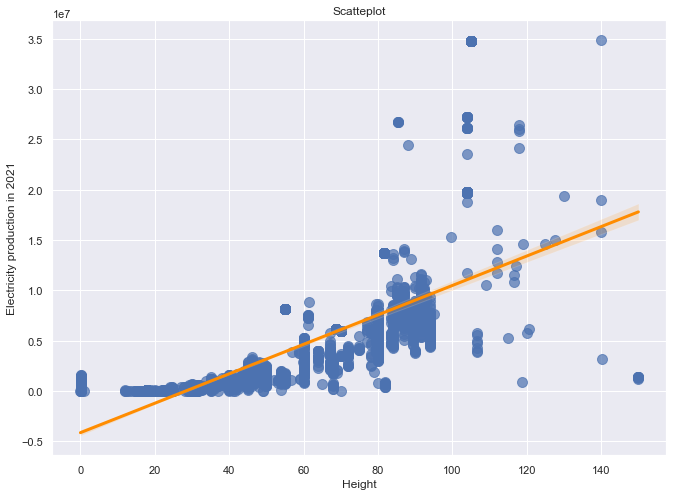

In [112]:
sns.set(rc={'figure.figsize':(11,8)})
sns.regplot(x=opg31['height'].astype(float),y=opg31['y2021'],
            line_kws={'lw': 3, 'color': 'darkorange'},
            scatter_kws={'s': 100, 'alpha': 0.7}); 
plt.xlabel('Height')
plt.ylabel('Electricity production in 2021')
plt.title('Scatteplot');

We can see clear possitive relationship between hight of mill and electricity production

In [113]:
OLS = smf.ols(formula='y2021 ~ height', data=opg31).fit() 
print(OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  y2021   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     7609.
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        19:10:27   Log-Likelihood:            -1.0340e+05
No. Observations:                6306   AIC:                         2.068e+05
Df Residuals:                    6304   BIC:                         2.068e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.131e+06   8.66e+04    -47.723      0.0

In [114]:
opg31['types'] = opg3.loc[:,'Type of location'].str.lower()

### Question 1  
1. Solve the model for the parameters above. 
2. Plot $v_1(m_1)$ and $v_2(m_2)$. Comment.
3. Plot the optimal consumption function $c_1^{*}(m_1)$ and $c_2^{*}(m_2)$ in one graph. Comment on the shapes of the functions.
4. Plot the optimal study choice function $\mathbb{I}^{s*}(m_1)$. Comment on the shape of the function.

### Question 2  
1. Given the wage premium on education, compute the **smallest** education cost $\tau$ such that an agent with $m_1 = 3.0$ will **no longer** choose to study.  
    **Hint**: there are different ways of obtaining that number. A bisection algorithm is one possibility. 


In [115]:
I = opg31.types == 'land'
Ii = opg31.types == 'hav'

In [116]:
opg31_l = opg31[I]
opg31_h = opg31[Ii]

In [117]:
print(opg31_l.shape)
print(opg31_h.shape)

(5676, 3)
(630, 3)


For on-shore only

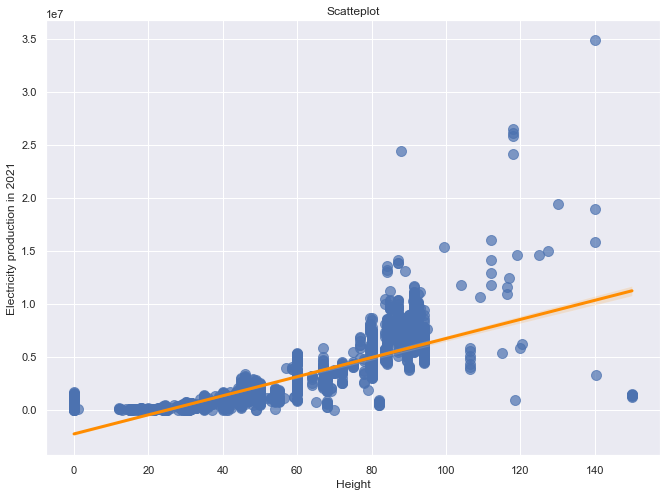

In [118]:
sns.set(rc={'figure.figsize':(11,8)})
sns.regplot(x=opg31_l['height'].astype(float),y=opg31_l['y2021'],
            line_kws={'lw': 3, 'color': 'darkorange'},
           scatter_kws={'s': 100, 'alpha': 0.7}); 
plt.xlabel('Height')
plt.ylabel('Electricity production in 2021')
plt.title('Scatteplot');

In [119]:
OLS = smf.ols(formula='y2021 ~ height', data=opg31_l).fit() 
print(OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  y2021   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                 1.217e+04
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        19:10:28   Log-Likelihood:                -88206.
No. Observations:                5676   AIC:                         1.764e+05
Df Residuals:                    5674   BIC:                         1.764e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -2.3e+06   3.89e+04    -59.182      0.0

For off-shore only

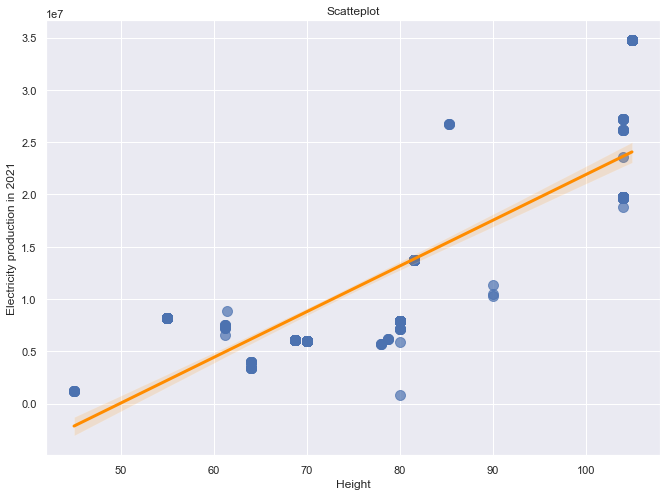

In [120]:
sns.set(rc={'figure.figsize':(11,8)})
sns.regplot(x=opg31_h['height'].astype(float),y=opg31_h['y2021'],
            line_kws={'lw': 3, 'color': 'darkorange'},
           scatter_kws={'s': 100, 'alpha': 0.7}); 
plt.xlabel('Height')
plt.ylabel('Electricity production in 2021')
plt.title('Scatteplot');

In [121]:
OLS = smf.ols(formula='y2021 ~ height', data=opg31_h).fit() 
print(OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  y2021   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     1312.
Date:                Wed, 25 May 2022   Prob (F-statistic):          5.65e-156
Time:                        19:10:28   Log-Likelihood:                -10595.
No. Observations:                 630   AIC:                         2.119e+04
Df Residuals:                     628   BIC:                         2.120e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.181e+07   9.55e+05    -22.844      0.0

We can see that most of mill are located on-shore. There are 'only' 630 mills located off-shore.
We can conclude that there is much greater possitive relationship for off-shore mills, which makes sens.

In [122]:
fin_2['types']= fin_2.loc[:,'Type of location'].str.lower()
fin_2['year2'] = fin_2['year2'].replace(np.nan, 2022)

In [123]:
I = fin_2.types == 'land'
Ii = fin_2.types == 'hav'

In [124]:
fin_2_l = fin_2[I]
fin_2_h = fin_2[Ii]

In [137]:
on = fin_2_l.groupby(['year'])['Capacity (kW)'].mean()
off = fin_2_h.groupby(['year'])['Capacity (kW)'].mean()

In [142]:
on = on[1991:2021]

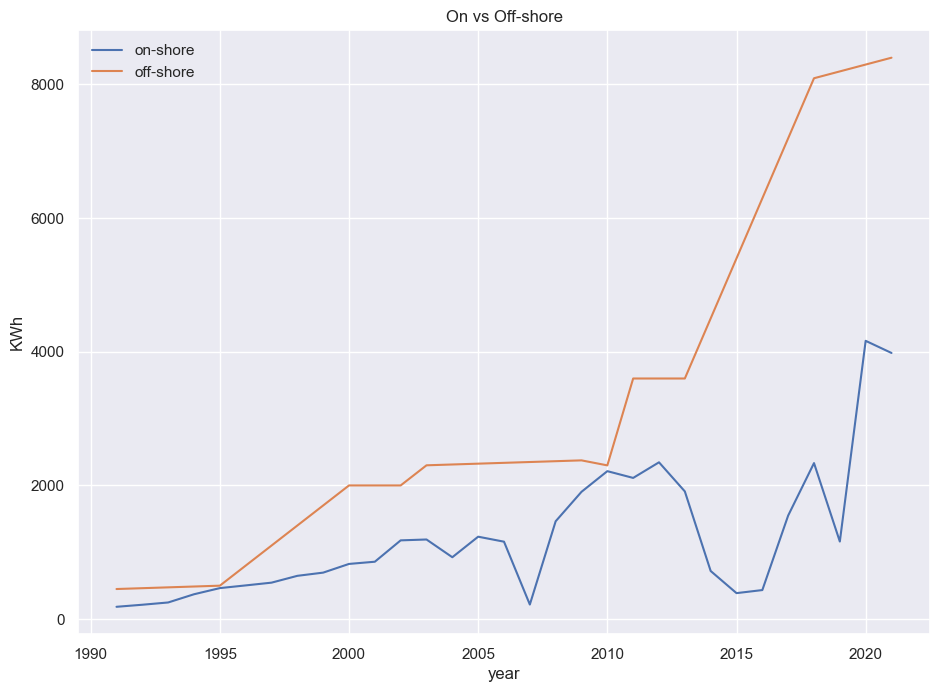

In [149]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('KWh')
ax.set_xlabel('year')
plt.title('On vs Off-shore')
ax.plot( on, label='on-shore')
ax.plot(off, label='off-shore')
plt.legend();

In [128]:
def f_approx(x, f, N, M):
    pass

**Note:** you can use the numpy functions `np.arccos` in $T_i$ and `np.cos` in $z_k$. 

### Question 2 


Evaluate `f_approx` at $x \in \{-0.5, 0.0, 0.98\}$ and report in each case also the deviation from the true value `f(x)`. 

Use the following   

In [129]:
f = lambda x: 1/(1+x**2) + x**3 - 0.5*x
N = 5
M = 8
xs = np.array([-0.5, 0.0, 0.98])